<a href="https://colab.research.google.com/github/yuanyuan233333/Bayesian-statistics/blob/main/TA8_ChangePointDetection_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Model for Change Point Detection in `stan`

In [1]:
!pip list | grep cmdstanpy
!pip list | grep arviz
# Install cmdstan -- Just for the first time!
from cmdstanpy import install_cmdstan
install_cmdstan()

cmdstanpy                          1.2.5
arviz                              0.20.0
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp6ht7xczv
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


True

In [2]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import os

from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

# Create ./stan folder if does not exists
if not os.path.exists("./stan"):
    os.mkdir("./stan")

$\newcommand{\iid}{\stackrel{\tiny\mbox{iid}}{\sim}}$
In statistical analysis, change detection or change point detection tries to identify times when the probability distribution of a stochastic process or time series changes. In general the problem concerns both detecting whether or not a change has occurred, or whether several changes might have occurred, and identifying the times of any such changes.

Specific applications, like step detection and edge detection, may be concerned with changes in the mean, variance, correlation, or spectral density of the process. More generally change detection also includes the detection of anomalous behavior: anomaly detection.

Offline change point detection it is assumed that a sequence of length T T is available and the goal is to identify whether any change point(s) occurred in the series. This is an example of post hoc analysis and is often approached using hypothesis testing methods. By contrast, online change point detection is concerned with detecting change points in an incoming data stream.

## Coal Mine Disaster dataset
We consider a dataset that contains information about coal mining disasters in the U.K. for the years 1851–1962. Such dataset comes from [Maguire, Pearson & Wynn (1952)][1] by has been revised and extended in [Jarrett (1979)][2]. Let us have a look at the data:

<!-- REFERENCES -->
[1]: https://doi.org/10.1093/biomet/39.1-2.168
[2]: https://doi.org/10.2307/2335266

In [4]:
# Import data
coal = pd.read_csv("coal.csv")
coal.head(5)

,year,events
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0


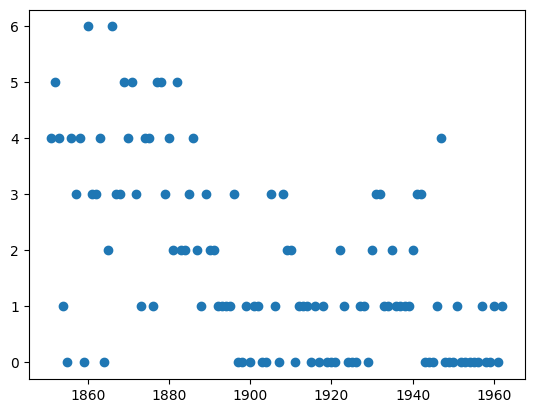

In [5]:
# Visualize data
plt.plot(coal.year, coal.events, 'o')
plt.show()

The variables are simple to interpret: for every year from 1851 to 1962 (variable `year`) the variable `event` collects the number of explosions in coal mines which resulted in 10 or more fatalities.

[Fonnesbeck et al. (2013, sec. 3.1)][1] provides a Poisson model of disaster $y_t$ in year $t$ with two rate parameters: an early rate $e$ and a late rate $l$ that change at a given point in time $s$. The full model expressed using a latent discrete parameter $s$ is

\begin{align*}
    y_t \mid s, e, l &\iid Poi\left( e\,\mathbb{I}(t < s) + l\,\mathbb{I}(t \geq s) \right) \quad t = 1,\dots,T \\
    s &\sim \mathcal{U}\left(\{1,\dots,T\}\right) \\
    e &\sim \mathcal{E}xp\left(r_e\right) \\
    l &\sim \mathcal{E}xp\left(r_l\right)
\end{align*}

<!-- REFERENCES -->
[1]: https://pymcmc.readthedocs.io/en/latest/tutorial.html#an-example-statistical-model

### Marginalizing out the discrete parameter

To code this model in `stan`, the discrete parameter $s$ must be marginalized out to produce a model defining the log of the probability function $\pi\left(\mathbf{y},e,l\right)$. The full joint probability factors as:

\begin{equation*}
    \pi\left(\mathbf{y},s,e,l\right) = \pi\left(\mathbf{y} \mid s,e,l\right)\pi(s)\pi(e)\pi(l).
\end{equation*}
Hence, marginalizing out $s$, we get the following:
\begin{equation*}
    \begin{array}{c c c}
        \pi\left(\mathbf{y},e,l\right) = & \pi\left(\mathbf{y} \mid e, l\right) & \times\,\,\pi(e)\pi(l), \\
         & \left[\sum_{s = 1}^{T}\pi\left(\mathbf{y}\mid s,e,l\right)\pi(s)\right] & \times\,\,\pi(e)\pi(l).
    \end{array}
\end{equation*}

Then, we can make explicit the law of $\pi\left(\mathbf{y} \mid e, l\right)$ as:

\begin{equation*}
    \sum_{s = 1}^{T} \mathcal{U}\left(s \mid \{1,\dots,T\}\right) \prod_{t = 1}^{T} Poi\left(y_t \mid e\,\mathbb{I}(t < s) + l\,\mathbb{I}(t \geq s) \right)
\end{equation*}

Remember that `stan` works in log scale, so we need to rewrite the above equation as follows:

\begin{equation*}
    \log\left[\sum_{s=1}^{T} \exp\left\{\log \mathcal{U}\Big(s \mid \{1,\dots,T\}\Big) + \sum_{t = 1}^{T} \log Poi\Big(y_t \mid e\,\mathbb{I}(t < s) + l\,\mathbb{I}(t \geq s)\Big) \right\}\right]
\end{equation*}

Let's code it in `stan`!

In [6]:
coal_change_point = """
functions {

    // Computes the marginal likelihood lpdf
    real marginal_likelihood_logpdf(array[] int obs, real early_rate, real late_rate) {

        // Deduce size of data and uniform contribution
        int T = size(obs);
        real log_unif = -log(T);

        // Compute contributions for log_sum_exp
        vector[T] lp = rep_vector(log_unif, T);
        for (s in 1:T) {
            for (t in 1:T) {
                lp[s] += poisson_lpmf(obs[t] | t < s ? early_rate : late_rate);
            }
        }

        // Return the value of the lpdf
        return log_sum_exp(lp);
    }
}

data {
    int<lower=1> T;
    array[T] int<lower=0> y;

    real<lower=0> r_e;
    real<lower=0> r_l;
}

transformed data {
    real log_unif = -log(T);
}

parameters {
    real<lower=0> e;
    real<lower=0> l;
}

model {
    // Likelihood
    target += marginal_likelihood_logpdf(y, e, l);

    // Prior
    e ~ exponential(r_e);
    l ~ exponential(r_l);
}
"""

# Write stan model to file
stan_file = "./stan/coal_change_point.stan"
with open(stan_file, "w") as f:
    print(coal_change_point, file=f)

# Compile stan model
coal_change_point = CmdStanModel(stan_file=stan_file)

22:35:53 - cmdstanpy - INFO - compiling stan file /content/stan/coal_change_point.stan to exe file /content/stan/coal_change_point
INFO:cmdstanpy:compiling stan file /content/stan/coal_change_point.stan to exe file /content/stan/coal_change_point
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=coal_change_point.stan /content/stan/coal_change_point
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=coal_change_point.stan --o=/content/stan/coal_change_point.hpp /content/stan/coal_change_point.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -

In [7]:
# Input data
cpc_data = {
    "T": coal.shape[0],
    "y": coal.events,
    "r_e": 1.0,
    "r_l": 1.0
}

# Algorithm parameters
algo_params = {
    "n_chains": 4,
    "n_burnin": 1000,
    "n_iter": 5000
}

# Sample
cpc_fit = coal_change_point.sample(data=cpc_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])

# Convert to arviz data type
chains = az.from_cmdstanpy(cpc_fit)

DEBUG:cmdstanpy:cmd: /content/stan/coal_change_point info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_8hpit_a/tb40as2j.json
22:44:36 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/coal_change_point', 'id=2', 'random', 'seed=13500', 'data', 'file=/tmp/tmp_8hpit_a/tb40as2j.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_pointut81zguc/coal_change_point-20250208224436_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/coal_change_point', 'id=3', 'random', 'seed=13500', 'data', 'file=/tmp/tmp_8hpit_a/tb40as2j.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_pointut81zguc/coal_change_point-20250208224436_3.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content

22:46:01 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/coal_change_point', 'id=1', 'random', 'seed=13500', 'data', 'file=/tmp/tmp_8hpit_a/tb40as2j.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_pointut81zguc/coal_change_point-20250208224436_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_8hpit_a/coal_change_pointut81zguc/coal_change_point-20250208224436_1.csv
 console_msgs (if any):
	/tmp/tmp_8hpit_a/coal_change_pointut81zguc/coal_change_point-20250208224436_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Defaul

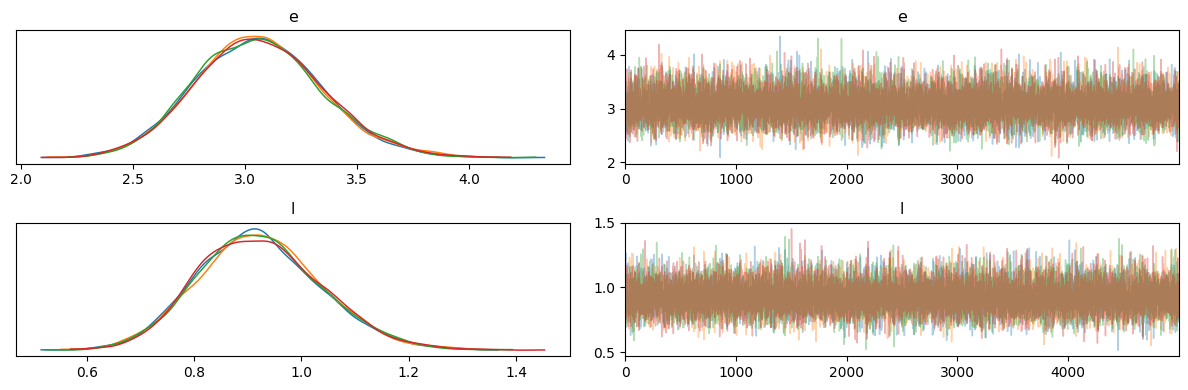

In [8]:
# Traceplots
az.plot_trace(chains, var_names=["e", "l"], compact=False)
plt.tight_layout()
plt.show()

In [9]:
# Summary of the MCMC run
az.summary(chains)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e,3.064,0.282,2.525,3.59,0.002,0.002,15920.0,12414.0,1.0
l,0.922,0.115,0.710,1.14,0.001,0.001,18820.0,13864.0,1.0


### Homework - Posterior distribution of the discrete change point
Since we have marginalized the likelihood w.r.t the $s$ variable, at this stage we do not have MCMC draws for $\pi\left(s \mid \mathbf{y}\right)$. We need to retrieve draws from its full conditional via the `generated_quantities` blocks. Thus, for $i = 1, \dots, T$:
\begin{align*}
    s = i \mid rest &\propto \pi\left(\mathbf{y} \mid s = i,e,l\right)\pi(s = i), \\
    &\propto \frac{1}{T} \prod_{t = 1}^{T} Poi\Big(y_t \mid e\,\mathbb{I}(t < i) + l\,\mathbb{I}(t \geq i) \Big).
\end{align*}
Thus it is a categorical random variable with probabilities proportional to the quantities above.

Let's code it in `stan`!

In [10]:
coal_change_point_v2 = """
functions {

    // Computes vector of lp
    vector compute_logp(array[] int obs, real early_rate, real late_rate){

        // Deduce size of data and uniform contribution
        int T = size(obs);
        real log_unif = -log(T);

        // Compute contributions vector and return
        vector[T] lp = rep_vector(log_unif, T);
        for (s in 1:T) {
            for (t in 1:T) {
                lp[s] += poisson_lpmf(obs[t] | t < s ? early_rate : late_rate);
            }
        }
        return lp;

    }

    // Computes the vector of probabilites for the posterior distribution of s
    vector compute_probs(vector lp) {
        return softmax(lp);
    }

    // Computes the marginal likelihood lpdf
    real marginal_likelihood_logpdf(vector lp){
        return log_sum_exp(lp);
    }
}

data {
    int<lower=1> T;
    array[T] int<lower=0> y;

    real<lower=0> r_e;
    real<lower=0> r_l;
}

transformed data {
    real log_unif = -log(T);
}

parameters {
    real<lower=0> e;
    real<lower=0> l;
}

model {
    // Likelihood
    target += marginal_likelihood_logpdf(compute_logp(y, e, l));

    // Prior
    e ~ exponential(r_e);
    l ~ exponential(r_l);
}

generated quantities {
    int<lower=1, upper=T> s = categorical_rng(compute_probs(compute_logp(y,e,l)));
}
"""

# Write stan model to file
stan_file = "./stan/coal_change_point_v2.stan"
with open(stan_file, "w") as f:
    print(coal_change_point_v2, file=f)

# Compile stan model
coal_change_point_v2 = CmdStanModel(stan_file=stan_file)

22:52:11 - cmdstanpy - INFO - compiling stan file /content/stan/coal_change_point_v2.stan to exe file /content/stan/coal_change_point_v2
INFO:cmdstanpy:compiling stan file /content/stan/coal_change_point_v2.stan to exe file /content/stan/coal_change_point_v2
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=coal_change_point_v2.stan /content/stan/coal_change_point_v2
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=coal_change_point_v2.stan --o=/content/stan/coal_change_point_v2.hpp /content/stan/coal_change_point_v2.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/l

In [11]:
# Input data
cpc_data = {
    "T": coal.shape[0],
    "y": coal.events,
    "r_e": 1.0,
    "r_l": 1.0
}

# Algorithm parameters
algo_params = {
    "n_chains": 4,
    "n_burnin": 1000,
    "n_iter": 5000
}

# Sample
cpc_fit = coal_change_point_v2.sample(data=cpc_data, chains=algo_params["n_chains"], parallel_chains=algo_params["n_chains"],
                                  iter_warmup=algo_params["n_burnin"], iter_sampling=algo_params["n_iter"])

# Convert to arviz data type
chains = az.from_cmdstanpy(cpc_fit)

DEBUG:cmdstanpy:cmd: /content/stan/coal_change_point_v2 info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_8hpit_a/cpyilnnz.json
23:01:10 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/coal_change_point_v2', 'id=1', 'random', 'seed=20924', 'data', 'file=/tmp/tmp_8hpit_a/cpyilnnz.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_point_v2ovd5lvmi/coal_change_point_v2-20250208230110_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/coal_change_point_v2', 'id=2', 'random', 'seed=20924', 'data', 'file=/tmp/tmp_8hpit_a/cpyilnnz.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_point_v2ovd5lvmi/coal_change_point_v2-20250208230110_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/stan/coal_change_point_v2', 'id=3', 'random', 'seed

23:02:34 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/stan/coal_change_point_v2', 'id=1', 'random', 'seed=20924', 'data', 'file=/tmp/tmp_8hpit_a/cpyilnnz.json', 'output', 'file=/tmp/tmp_8hpit_a/coal_change_point_v2ovd5lvmi/coal_change_point_v2-20250208230110_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp_8hpit_a/coal_change_point_v2ovd5lvmi/coal_change_point_v2-20250208230110_1.csv
 console_msgs (if any):
	/tmp/tmp_8hpit_a/coal_change_point_v2ovd5lvmi/coal_change_point_v2-20250208230110_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      e

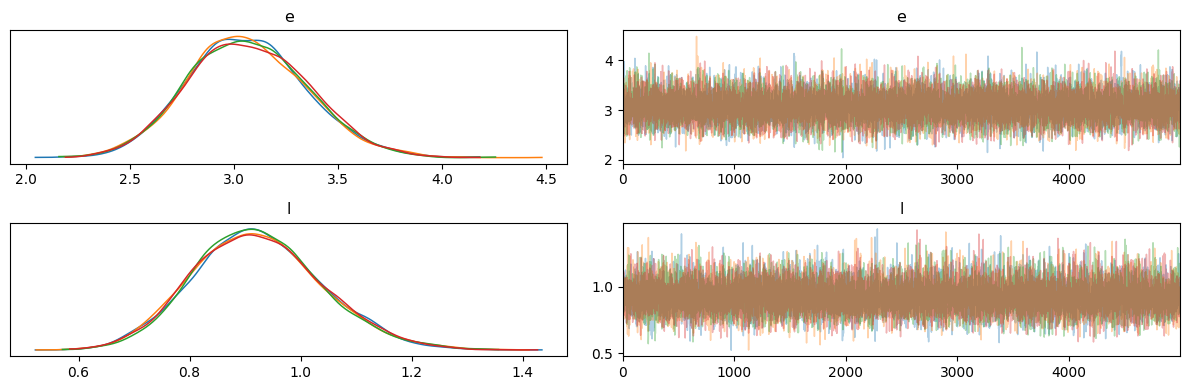

In [12]:
# Traceplots for early and late rates
az.plot_trace(chains, var_names=["e", "l"], compact=False)
plt.tight_layout()
plt.show()

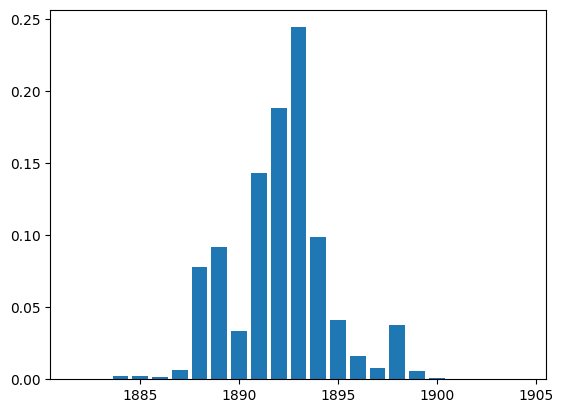

In [13]:
# Posterior distribution of s
s_chain = np.hstack(chains.posterior.s).astype(int)

# Posterior barplot for s
x, y = np.unique(s_chain, return_counts=True)
plt.bar(coal.year[x], y/y.sum())
plt.show()

The posterior mode of such distribution can be easily computed:

In [14]:
print("Posterior Mode: {0}".format(coal.year[x[y == y.max()]].to_numpy().squeeze()))

Posterior Mode: 1893
